In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import numpy as np

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load the bug reports dataset
data = pd.read_excel("train.xlsx")
bug_reports = data['report']

# Tokenize bug reports and remove empty strings or tokens consisting only of spaces
stop_words = set(stopwords.words('english'))
tokenized_bug_reports = [[word.lower() for word in word_tokenize(report) if word.strip() and word.strip() not in stop_words] for report in bug_reports]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_bug_reports, vector_size=100, window=5, min_count=1, sg=1)





In [5]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_bug_reports, vector_size=100, window=5, min_count=1, sg=1)

In [6]:
tokenized_bug_reports[:3]


[['``',
  'for',
  'event',
  'bookmarked',
  'projects',
  "''",
  'option',
  'sending',
  'notifications',
  'non-member',
  'bookmarked',
  'projects'],
 ['switch', 'using', 'full', 'l10n', 'id', "'s", 'urlbar'],
 ['consider', 'removing', 'hasicon', 'property', 'simplify', 'styling']]

In [7]:
# Save or load Word2Vec model (optional)
# word2vec_model.save("word2vec_model.bin")
# word2vec_model = Word2Vec.load("word2vec_model.bin")

In [8]:
# Get the word vectors for a specific word
test_word = "email"
word_vector = word2vec_model.wv[test_word]

# Print similar words to a given word
similar_words = word2vec_model.wv.most_similar(test_word)

print(similar_words)

[('mails', 0.9208160638809204), ('security', 0.9033337235450745), ('sending', 0.897658109664917), ('ignoring', 0.8975818753242493), ('e-mail', 0.8942431211471558), ('per', 0.8900400400161743), ('asynchronously', 0.8863750696182251), ('mail', 0.8855650424957275), ('blockquote', 0.8854019641876221), ('header', 0.8843525052070618)]


In [9]:
# Print the word embeddings
print("Word Embeddings:")
for word in word2vec_model.wv.index_to_key[:10]:
    print(f"{word}: {word2vec_model.wv[word]}")

Word Embeddings:
]: [-0.48775527  0.34751374  0.12362641  0.12933517 -0.40709224 -0.36200988
  0.42077538  0.8169236   0.06179025 -0.31451592  0.37885264 -0.32001513
 -0.04421509  0.44466314 -0.5105584  -0.06969985  0.47644824  0.08947372
 -0.5501806  -1.0166625   0.21029821  0.17860776  0.53065133 -0.27036846
  0.33360538  0.09166688 -0.32983047  0.1666479  -0.56393504 -0.267935
 -0.3856317  -0.03387238  0.33059317 -0.7794229   0.15844497  0.51239884
  0.5724359  -0.4858555  -0.2559945  -0.5791774  -0.23015982  0.15019621
 -0.69442743 -0.25194573  0.5345018   0.01438071 -0.24547169  0.36738542
  0.3460121   0.6390299   0.21682116  0.07913808 -0.14817394 -0.03391649
  0.1766783  -0.05065046  0.5724981  -0.12562102 -0.8372116   0.57444805
 -0.05378275 -0.21728921 -0.70771307 -0.36021465 -0.12062174  0.43719304
 -0.10795347  0.2691947  -0.05148944  0.23651616 -0.09520102  0.32274076
 -0.00400902 -0.49952772  0.14152516 -0.0296546   0.1310525   0.09713107
 -0.14527322  0.01037022 -0.39873

In [10]:
# Derive document embeddings by averaging word embeddings
document_embeddings = np.array([np.mean([word2vec_model.wv[word] for word in report if word in word2vec_model.wv], axis=0) for report in tokenized_bug_reports])

print(document_embeddings.shape)

(14710, 100)


In [11]:
#  visualize clusters or perform further analysis
import matplotlib.pyplot as plt

# Visualize clusters
def visualize_clusters(embeddings, clusters):
    # Define colors for each cluster (including noise points)
    unique_clusters = np.unique(clusters)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    # Plot data points with cluster assignments
    for cluster_id, color in zip(unique_clusters, colors):
        if cluster_id == -1:
            # Noise points (cluster_id = -1)
            plt.scatter(embeddings[clusters == cluster_id][:, 0], embeddings[clusters == cluster_id][:, 1], color='black', label='Noise')
        else:
            # Core and border points
            plt.scatter(embeddings[clusters == cluster_id][:, 0], embeddings[clusters == cluster_id][:, 1], color=color, label=f'Cluster {cluster_id}')

    # Add legend and labels
    plt.legend()
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Clustering')

    # Show plot
    plt.show()


In [12]:
import csv

def store_cluster_assignments(clusters, bug_reports, output_file):
    # Create a dictionary to store bug reports for each cluster
    cluster_reports = {}
    for i, cluster_label in enumerate(clusters):
        if cluster_label not in cluster_reports:
            cluster_reports[cluster_label] = []
        cluster_reports[cluster_label].append(bug_reports[i])

    # Write cluster assignments to CSV file
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Cluster', 'Bug Report'])
        for cluster_label, reports in cluster_reports.items():
            if cluster_label == -1:
                cluster_name = 'Noise'
            else:
                cluster_name = f'Cluster {cluster_label}'
            for report in reports:
                writer.writerow([cluster_name, report])

    print(f"Cluster assignments saved to '{output_file}'")


In [13]:
from sklearn.cluster import KMeans

# Create KMeans object
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit KMeans clustering on document embeddings
kmeans.fit(document_embeddings)

# Predict cluster labels
kmeans_clusters = kmeans.predict(document_embeddings)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


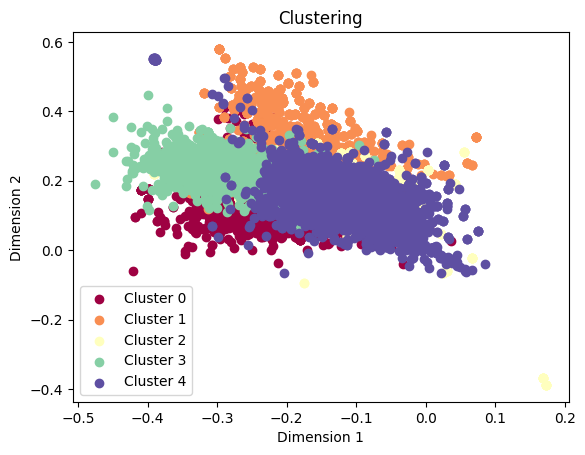

In [14]:

# Visualize clusters (optional)
visualize_clusters(document_embeddings, kmeans_clusters)




In [15]:
# Store cluster assignments in CSV file (optional)
store_cluster_assignments(kmeans_clusters, bug_reports, "kmeans_cluster_assignments.csv")

Cluster assignments saved to 'kmeans_cluster_assignments.csv'


In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Silhouette Score
silhouette_avg = silhouette_score(document_embeddings, kmeans_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Compute Davies–Bouldin Index
db_index = davies_bouldin_score(document_embeddings, kmeans_clusters)
print(f"Davies–Bouldin Index: {db_index}")


#the Silhouette Score is 0.080 and the Davies–Bouldin Index is 2.053.
# These values suggest that the clustering quality may not be optimal,
# as the Silhouette Score is relatively low and the Davies–Bouldin Index is higher than expected.

Silhouette Score: 0.23802728950977325
Davies–Bouldin Index: 1.4320354436095655
